# Data Analysis for Data-Driven Water Temperature Prediction 

- Analysing the dataset created by run_example.sh
- Modelling statistical predictions



TODO:
 - Tune processing and storing of observational data sets (to suite whatever code that will use the data sets)
 - Prototype naive prediction
 - Prototype linear regression
 - Prototype random forest
 - Prototype simple XGBoost
 - Prototype simple ANN (with Tensorflow and Keras?)
 - ...

In [2]:
import pandas as pd 
import datetime
import numpy as np

import matplotlib.pyplot as plt

import matplotlib.dates as mdates
mydates = mdates.DateFormatter('%m-%d')

## Reading and Preprocessing data set 

In [3]:
# Read the example data
original_data = pd.read_csv("dataset_sjostrand.csv")
N = len(original_data)

original_data["time"] = pd.to_datetime(original_data["time"])
original_data = original_data.set_index("time")

years = list(dict.fromkeys(list(original_data.index.year)))

In [4]:
# NOTE: Some columns contain only integer values

# Casting to all entries to floats
for column in original_data.columns:
    if original_data[column].dtype != "float64":
        original_data[column] = original_data[column].astype(float)

In [5]:
# NOTE: Some of the libraries require special attention if the data contains NaNs
clean_nan = True

if clean_nan:
    data = original_data.dropna()

In [7]:
# TEMP!!! 
# hard coded hand pick for test and train!

# Split in train and test data
# where the full last year becomes the test set 
start_train = datetime.datetime.strptime("2016-01-01T00:00 +0000", "%Y-%m-%dT%H:%M %z")
end_train = datetime.datetime.strptime("2019-12-31T23:59 +0000", "%Y-%m-%dT%H:%M %z")
train = data[start_train : end_train]

start_test = datetime.datetime.strptime("2020-01-01T00:00 +0000", "%Y-%m-%dT%H:%M %z")
end_test = datetime.datetime.strptime("2020-12-31T23:59 +0000", "%Y-%m-%dT%H:%M %z")
test = data[start_test : end_test]

## Data Exploration

Functionalities for the plotting of time series 

In [8]:
def plot_timeseries_all_years(param):
    """Plotting timeseries of the param column 
    for all years in the data set 
    over the same date in year x-axis"""
    fig, ax = plt.subplots()
    for year in years:
        print(year)
        start_time = datetime.datetime.strptime(str(year)+"-01-01T00:00 +0000", "%Y-%m-%dT%H:%M %z")
        end_time = datetime.datetime.strptime(str(year)+"-12-31T23:59 +0000", "%Y-%m-%dT%H:%M %z")
        ax.plot(data[data.index.year==year]["water_temp"].dropna().index+pd.offsets.DateOffset(year=2000),
            data[data.index.year==year]["water_temp"].dropna())

    ax.xaxis.set_major_formatter(mydates)
    plt.legend(years)
    plt.xlabel("date [MM-DD]")
    plt.ylabel(param)
    plt.title("Time series")


2016
2017
2018
2019
2020
2021


/home/florianb/miniconda3/envs/datadriven/lib/python3.7/site-packages/pandas/core/arrays/datetimes.py:743: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex
  PerformanceWarning,
/home/florianb/miniconda3/envs/datadriven/lib/python3.7/site-packages/pandas/core/arrays/datetimes.py:743: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex
  PerformanceWarning,
/home/florianb/miniconda3/envs/datadriven/lib/python3.7/site-packages/pandas/core/arrays/datetimes.py:743: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex
  PerformanceWarning,
/home/florianb/miniconda3/envs/datadriven/lib/python3.7/site-packages/pandas/core/arrays/datetimes.py:743: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex
  PerformanceWarning,
/home/florianb/miniconda3/envs/datadriven/lib/python3.7/site-packages/pandas/core/arrays/datetimes.py:743: PerformanceWarning: Non-vecto

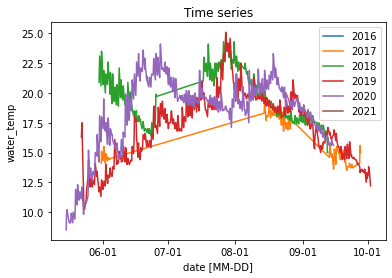

In [9]:
plot_timeseries_all_years("water_temp")

## Data Analysis

Learning a data-driven predictor

In [10]:
def plot_test_vs_truth(prediction, test):
    """Plotting timeseries of the prediciton against the truth"""
    fig, axs = plt.subplots(1,2)
    fig.set_figheight(6)
    fig.set_figwidth(12)
    # Time series plot
    axs[0].plot(test["water_temp"].index, test["water_temp"])
    axs[0].plot(test["water_temp"].index, prediction)


    axs[0].legend(["truth","prediction"])
    axs[0].set_xlabel("date")
    axs[0].set_ylabel("water_temp [degC]")
    axs[0].set_title("True time series vs predicted on test set")
    axs[0].tick_params(axis='x', rotation=45)

    # Bias plot
    axs[1].plot(prediction, test["water_temp"], "+")
    axs[1].plot(np.linspace(8,24), np.linspace(8,24))

    axs[1].set_xlabel("predicted water_temp [degC]")
    axs[1].set_ylabel("true water_temp [degC]")
    axs[1].set_title("Predicted test vs true test")    


The dataset is not extendable due to the lack of data!


### Naive Prediction

The naive prediction assumes that the `water_temp` does not change

In [11]:
prediction = original_data["water_temp"].shift(1)[start_test:end_test].dropna()
prediction = prediction.loc[np.isin(prediction.index,test.index)]

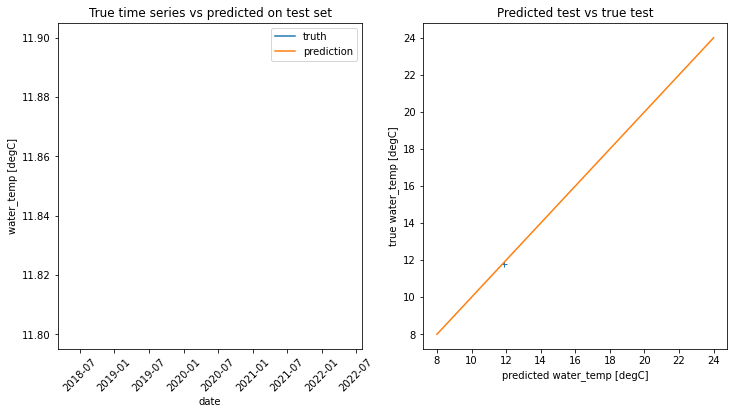

In [12]:
plot_test_vs_truth(prediction, test.loc[np.isin(test.index, prediction.index)])

### NorKyst800 Prediction

Relying on NorKyst800 Forecast without further data analysis


In [13]:
prediction = test["norkyst_water_temp"]

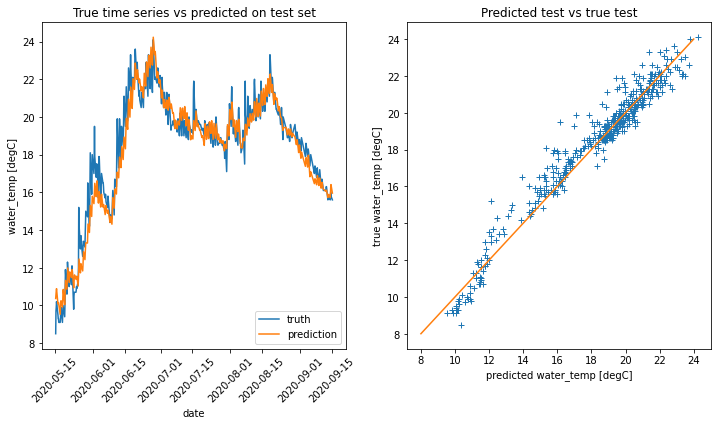

In [14]:
plot_test_vs_truth(prediction, test)

### Regressoion-Type Algorithms

The atmospheric observations at time $t$, the NorKyst800 forecast for time $t$ and the `water_temp` at time $t-1$ are used as covariates in order to model the `water_temp` at time $t$ as response.

NOTE: 
- we use atmospheric forecast values for $t$, but also older information may be of interest!

In [15]:
# Covariates and response
X = train.loc[:, data.columns!="water_temp"]
Y = train["water_temp"]

#### Linear Regression


In [16]:
from sklearn.linear_model import LinearRegression

# Train linear regression model
linreg = LinearRegression()
linreg.fit(X,Y)

LinearRegression()

In [17]:
# Test model
prediction_labels = linreg.predict(test.loc[:, data.columns!="water_temp"])
prediction = pd.DataFrame(prediction_labels)
prediction["time"] = test.index
prediction = prediction.set_index("time")

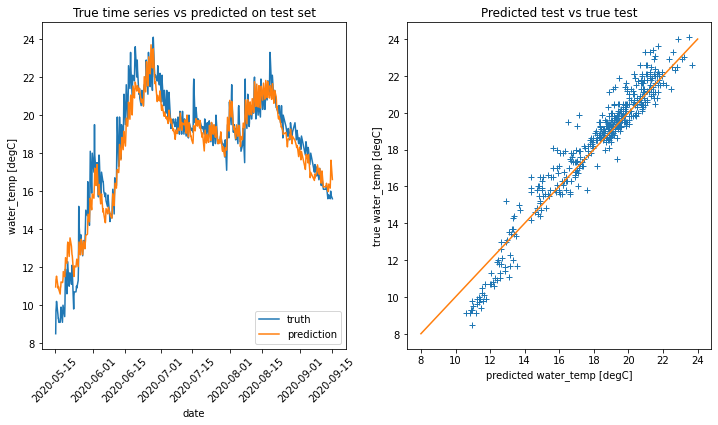

In [18]:
plot_test_vs_truth(prediction, test)

Analysing the regression coefficients 

In [19]:
df_importance = pd.concat([pd.DataFrame(np.transpose(linreg.coef_), columns=["coeff"]), pd.DataFrame(X.columns, columns=["covariate"])], axis = 1).sort_values("coeff", ascending=False, ignore_index=True).set_index("covariate")
df_importance

,coeff
covariate,
norkyst_water_temp,8.081375e-01
air_temperature_2m,1.058112e-01
cloud_area_fraction,4.260103e-02
integral_of_surface_downwelling_shortwave_flux_in_air_wrt_time,-2.282578e-07
wind_speed_10m,-8.168195e-02


#### Random Forest

We use all default settings (`n_ensembles` aka the number of trees = 100, `max_features` aka the number of features to split on = sqrt(n_features))

In [22]:
from sklearn.ensemble import RandomForestRegressor
# train model
rf = RandomForestRegressor()
rf.fit(X,Y)

RandomForestRegressor()

In [23]:
# Test model
prediction_labels = rf.predict(test.loc[:, data.columns!="water_temp"])
prediction = pd.DataFrame(prediction_labels)
prediction["time"] = test.index
prediction = prediction.set_index("time")

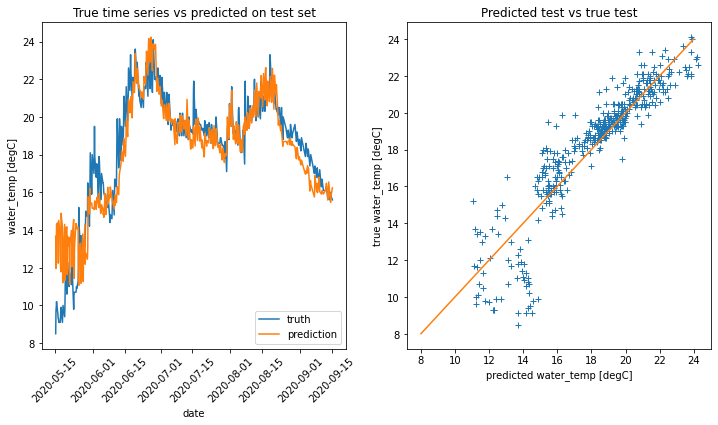

In [24]:
plot_test_vs_truth(prediction, test)

In [25]:
importance_values = rf.feature_importances_
importance = pd.DataFrame(importance_values, columns=["importance"])
importance["element"] = X.columns
importance = importance.set_index("element")
importance = importance.sort_values(by="importance", ascending=False)
importance

,importance
element,
norkyst_water_temp,0.898328
air_temperature_2m,0.033110
integral_of_surface_downwelling_shortwave_flux_in_air_wrt_time,0.028365
wind_speed_10m,0.025286
cloud_area_fraction,0.014912


#### XGBoost

Using only default, however parameter tuning would be important for boosting though.


In [27]:
from xgboost import XGBRegressor
# train model
xgb = XGBRegressor()
xgb.fit(X,Y)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=20, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [28]:
# Test model
prediction_labels = xgb.predict(test.loc[:, data.columns!="water_temp"])
prediction = pd.DataFrame(prediction_labels)
prediction["time"] = test.index
prediction = prediction.set_index("time")

/home/florianb/miniconda3/envs/datadriven/lib/python3.7/site-packages/xgboost/data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


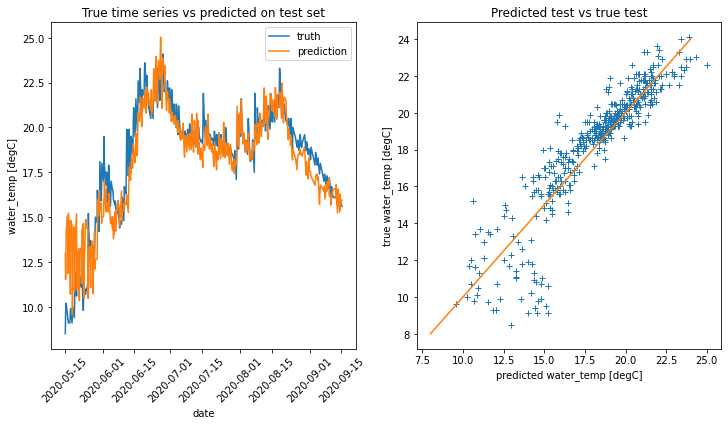

In [29]:
plot_test_vs_truth(prediction, test)

### Neural Nets

In [31]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

# NOTE: without a normalizer the results are shifted
normalizer = preprocessing.Normalization()
normalizer.adapt(np.array(X))

# Building the neural net
# NOTE: The design of the net has major influence on the results!
# For details see documentation of tensorflow
model = tf.keras.Sequential([
    normalizer,
    layers.Dense(10, activation="relu"),
    layers.Dense(10, activation="relu"),
    layers.Dense(5),
    layers.Dense(units=1)
])

# Configuring with loss function and optimization algorithm
model.compile(
    optimizer=tf.optimizers.Adam(learning_rate=0.1),
    loss='mean_absolute_error')

# Training
# NOTE: The training results are very random such that the results from every run are fundamentally different
model.fit(X, Y,
    epochs=200,
    verbose=0,
    validation_split = 0.2)

In [32]:
#test
prediction_labels = model.predict(test.loc[:, data.columns!="water_temp"])
prediction = pd.DataFrame(prediction_labels)
prediction["time"] = test.index
prediction = prediction.set_index("time")

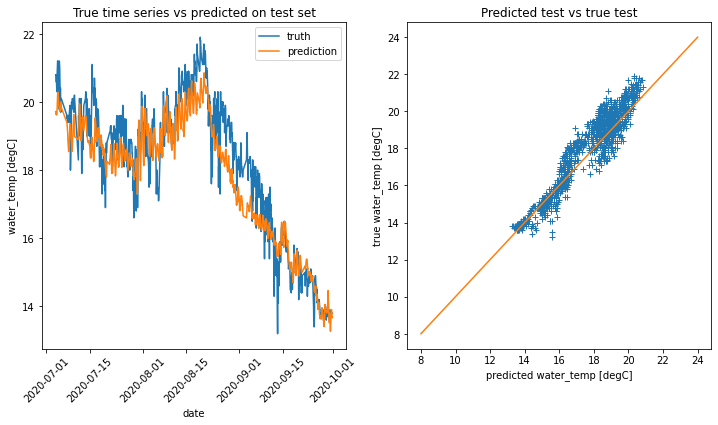

In [34]:
plot_test_vs_truth(prediction, test)

### Temporal Fusion Transformer 

https://arxiv.org/pdf/1912.09363.pdf

In [30]:
from darts.models import TFTModel

ImportError: cannot import name 'TFTModel' from 'darts.models' (unknown location)